In [ ]:
import numpy as np
import itertools

def multichoose(n,k):
    '''The maximum value that the sum of elements in each combination should not exceed.
    Returns all possible permitations of n number which sum is below or
    equal to k '''
    if k < 0 or n < 0: return "Error"
    if not k: return [[0]*n]
    if not n: return []
    if n == 1: return [[k]]
    return [[0]+val for val in multichoose(n-1,k)] + \
        [[val[0]+1]+val[1:] for val in multichoose(n,k-1)]

class ConfidentialityGame():
    ''' Class for the confidentiality game '''
    attack_strategies = None
    defend_strategies = None

    def __init__(self, tree, K=5, a=0.3, attacker_budget=1.0,
                        defender_budget=1.5):
        ''' Constructor for the confidentiality game.

        Arguments:

        tree: list of Nodes defining the tree structure of the game
        K: resulution of the strategy space (integer > 1)
        a: the detection rate
        attacker_budget: the budget of the attacker population
        defender_budget: the budget of the defender population
        '''
        self.K = K
        self.a = a
        self.attacker_budget = attacker_budget
        self.defender_budget = defender_budget
        self.N = len(tree)
        self.tree = tree
        print('Initializing game')
        print('# \t v_i \t C_A \t C_D \t s^* \t t^*')
        for ni, node in enumerate(self.tree):
            value = node.value
            s_star = node.cost_defence/value/(1-self.a)
            '''subtracting it from 1.0 gives the fraction of the node's 
            value that the attacker retains in case the attack is successful and not detected.'''
            t_star = 1.0-node.cost_attack/value/(1-self.a)
            print('{0:3d} \t {1:0.2f} \t {2:0.2f} \t {3:0.2f} ' \
                    '\t {4:0.2f} \t {5:0.2f}'.format(tree.index(node), value, 
                            node.cost_attack,
                        node.cost_defence, s_star, t_star))

    def attacker_strategies(self):
        ''' Returns all possible attacker strategies as a numpy array of
        dimensions <number of strategies> x <number of nodes in tree> '''
        if self.attack_strategies is None:
            # K is a parameter used to define the resolution of the strategy space
            budget = int(self.K*self.attacker_budget)
            self.attack_strategies = np.asarray(
                    multichoose(self.N, budget))/float(self.K)
        return self.attack_strategies

    def defender_strategies(self):
        ''' Returns all possible defender strategies as a numpy array of
        dimensions <number of strategies> x <number of nodes in tree> '''
        if self.defend_strategies is None:
            budget = int(self.K*self.defender_budget)
            self.defend_strategies = np.asarray(
                        multichoose(self.N, budget))/float(self.K)
        return self.defend_strategies

    def attacker_utility(self, attack_strategy, defence_strategies):
        ''' Returns the utility of a given attack strategy for each of a list
        of given defence strategies

        Arguments:
        
        attack_strategy: numpy array of size <number of nodes in tree> giving
                         a specified attack strategy
        defence_strategies: numpy array of size <number of strategies> x
                            <number of nodes in tree>
        
        Returns:

        utility: numpy array of attacker utilities of size <number of
                 strategies>

        '''
        utility = np.zeros(defence_strategies.shape[0])
        for ni, node in enumerate(self.tree):
            children_utility = np.zeros(defence_strategies.shape[0])
            for childnode in node.children:
                children_utility += childnode.value\
                        *attack_strategy[ni]\
                        *(1-self.a)*(1-defence_strategies[:,
                            self.tree.index(childnode)])
            utility += node.value*attack_strategy[ni]*(1-self.a)\
                    *(1.0-defence_strategies[:, ni]) \
                    - attack_strategy[ni]*node.cost_attack \
                    + children_utility
        return utility

    def defender_utility(self, attack_strategies, defence_strategy):
        ''' Returns the utility of a given defence strategy for each of a list
        of given attack strategies

        Arguments:
        
        attack_strategies: numpy array of size <number of strategies> x
                            <number of nodes in tree>
        defence_strategy: numpy array of size <number of nodes in tree> giving
                         a specified defence strategy

        Returns:

        utility: numpy array of attacker utilities of size <number of
                 strategies>

        '''
        utility = np.zeros(attack_strategies.shape[0])
        for ni, node in enumerate(self.tree):
            children_utility = np.zeros(attack_strategies.shape[0])
            for childnode in node.children:
                children_utility += childnode.value\
                        *attack_strategies[:, ni]\
                        *(1-self.a)*(1-defence_strategy[
                            self.tree.index(childnode)])
            utility += - node.value*attack_strategies[:, ni]*(1-self.a)\
                    *(1.0-defence_strategy[ni]) \
                    - defence_strategy[ni]*node.cost_defence \
                    - children_utility
        return utility


In [ ]:
class Node(object):
    '''Class for a node in an tree.'''

    def __init__(self, children=None, cost_attack=1.0,
            cost_defence=1.0, value=3.0):
        ''' Constructor for the Node class

        Arguments:

        children: list of children nodes
        cost_attack: the cost of attacking the node, C_A
        cost_defence: the cost of defending a node, C_D
        value: the value of the node, v
        '''
        self.value = value
        self.cost_attack = cost_attack
        self.cost_defence = cost_defence
        self.children = []
        if children is not None:
            for child in children:
                self.add_child(child)
        
    def add_child(self, node):
        ''' Adds a node to the list of children '''
        assert isinstance(node, Node)
        self.children.append(node)

    def validate(self, a):
        ''' Raises error if the parameters of the node break constraints of
        the game 
        
        Arguments:

        a: the detection rate of the game
        '''
        if self.cost_attack > self.value*(1-a):
            raise ValueError('Attacking an undefended node must pay off')
        if self.cost_defence > self.value*(1-a):
            raise ValueError('Defending a fully attacked node must pay off')


In [ ]:
import numpy as np
import sys

class Population:
    ''' Class for a population of attackers and defender in a given game '''

    def __init__(self, game, attacker_distribution, defender_distribution,
                    replicator='REQN', k=0.2, dt=0.1, delta = 0.1):
        ''' Constructor for the Population class

        Arguments:

        game: a Game object
        attacker_distribution: normalized numpy array of size 
                               <number of strategies> giving the attacker 
                               population distribution 
        defender_distribution: normalized numpy array of size 
                               <number of strategies> giving the defender
                               population distribution 
        replicator: the type of replicator dynamic to use. 
        k: (only applies to truncation replicator) the fraction of the
           population to truncate
        dt: (only applies to the REQN replicator) the time step between 
            generations in the 
        delta: (only applies to the REQN replicator) parameter scaling the 
               random noise introduced between each generation

        '''
        self.game = game
        self.replicator = replicator
        self.k = k
        self.dt = dt
        self.attacker_population = attacker_distribution
        self.defender_population = defender_distribution
        self.delta = delta/attacker_distribution.shape[0]
        self.attacker_strategies = game.attacker_strategies()
        self.defender_strategies = game.defender_strategies()

    def calculate_utilities(self):
        ''' Calculates average utilities for both attackers and defenders '''
        self.average_utility_attacker = self.average_payoff_attacker()
        self.average_utility_defender = self.average_payoff_defender()

    def replicate(self):
        ''' Updates the attacker and defender populations using a method 
        given in the class variable replicator '''
        self.calculate_utilities()
        if self.replicator == 'REQN':
            '''Calculate attacker population change, The objective of this part is to calculate 
            the change in the population of attackers (dp_s) based on the difference between the 
            expected payoff of each attacker strategy and the average utility of the attackers in the current population.'''
            dp_s = np.zeros(len(self.attacker_population))
            for si, attacker in enumerate(self.attacker_population):
                dp_s[si] = attacker*(self.expected_payoff_attacker(\
                        self.attacker_strategies[si, :]) \
                        - self.average_utility_attacker)

            # Calculate defender population change
            dp_t = np.zeros(len(self.defender_population))
            for ti, defender in enumerate(self.defender_population):
                dp_t[ti] = defender*(self.expected_payoff_defender(\
                        self.defender_strategies[ti, :]) \
                        - self.average_utility_defender)

            # Update population
            self.attacker_population = self.attacker_population + self.dt*dp_s
            self.defender_population = self.defender_population + self.dt*dp_t

            # Add random fluctuation
            N_A = self.attacker_population.shape[0]
            N_D = self.defender_population.shape[0]
            self.attacker_population += self.delta*np.random.rand(N_A)/N_A
            self.defender_population += self.delta*np.random.rand(N_D)/N_D

            # Remove any negative populations
            self.attacker_population[self.attacker_population < 0] = 0
            self.defender_population[self.defender_population < 0] = 0

            # Normalization step
            '''The purpose of normalization is to ensure that the population 
            distributions remain valid probability distributions, 
            meaning that the sum of the population probabilities is equal to 1.'''
            self.attacker_population = self.attacker_population\
                    /np.sum(self.attacker_population)
            self.defender_population = self.defender_population\
                    /np.sum(self.defender_population)

        elif self.replicator == 'truncation':
            '''the distribution of strategies among attackers and defenders in a game, 
            where each strategy is associated with a certain probability of being chosen by a player.'''
            # Extract subset of strategies with non-zero population
            attackers_nonzero = np.nonzero(self.attacker_population)[0]
            # These lines create lists of attacker and defender strategies corresponding to non-zero population elements.
            s_nonzero = list([self.attacker_strategies[i, :] for i in 
                    attackers_nonzero])
            defenders_nonzero = np.nonzero(self.defender_population)[0]
            t_nonzero = list([self.defender_strategies[i, :] for i in
                    defenders_nonzero])
            # These lines create lists of attacker and defender strategies corresponding to non-zero population elements.
            attacker_population_nonzero = \
                    self.attacker_population[attackers_nonzero]
            defender_population_nonzero = \
                    self.defender_population[defenders_nonzero]

            # Calculate utilities for every strategy (of non-zero population)
            utilities_attacker = np.zeros(len(s_nonzero))
            utilities_defender = np.zeros(len(t_nonzero))
            for si, s in enumerate(s_nonzero):
                utilities_attacker[si] = self.expected_payoff_attacker(s)

            for ti, t in enumerate(t_nonzero):
                utilities_defender[ti] = self.expected_payoff_defender(t)

            # Sort by utility
            sorted_attackers = np.argsort(utilities_attacker)
            sorted_defenders = np.argsort(utilities_defender)

            # Move population for lowest k percent to highest k percent
            for ik in range(0, int(self.k*sorted_attackers.size)):
                attacker_population_nonzero[sorted_attackers[ik]] += \
                        attacker_population_nonzero[sorted_attackers[-ik-1]]
                attacker_population_nonzero[sorted_attackers[-ik-1]] = 0.0
            for ik in range(0, int(self.k*sorted_defenders.size)):
                defender_population_nonzero[sorted_defenders[ik]] += \
                        defender_population_nonzero[sorted_defenders[-ik-1]]
                defender_population_nonzero[sorted_defenders[-ik-1]] = 0.0

            # Update full population
            self.attacker_population[attackers_nonzero] = \
                                    attacker_population_nonzero
            self.defender_population[defenders_nonzero] = \
                                    defender_population_nonzero

    def expected_payoff_attacker(self, attacker_strategy):
        ''' Calculates the expected payoff associated with a given attacker
        strategy

        Arguments:

        attacker_strategy: numpy array of size <number of nodes in tree>
                           giving an attacker strategy

        Returns:

        expected_payoff
        '''
        expected_payoff = np.inner(self.game.attacker_utility(attacker_strategy,
                               self.defender_strategies),
                                       self.defender_population)
        return expected_payoff
    
    def expected_payoff_defender(self, defender_strategy):
        ''' Calculates the expected payoff associated with a given defender
        strategy

        Arguments:

        defender_strategy: numpy array of size <number of nodes in tree>
                           giving an defender strategy

        Returns:

        expected_payoff
        '''
        expected_payoff = np.inner(self.game.defender_utility(\
                    self.attacker_strategies,
                    defender_strategy),self.attacker_population)
        return expected_payoff
    
    def average_payoff_attacker(self):
        ''' Calculates the average payoff of an attacker given the current
        attacker and defender populations '''
        average_payoff = 0.0
        for ia in range(0, self.attacker_strategies.shape[0]):
            average_payoff += self.expected_payoff_attacker( \
                    self.attacker_strategies[ia, :]) \
                    *self.attacker_population[ia]
        return average_payoff

    def average_payoff_defender(self):  
        ''' Calculates the average payoff of a defender given the current
        attacker and defender populations '''
        average_payoff = 0.0
        for di in range(0, self.defender_strategies.shape[0]):
            average_payoff += self.expected_payoff_defender( \
                    self.defender_strategies[di, :]) \
                    *self.defender_population[di]
        return average_payoff

    def get_attack_profiles(self):
        ''' Returns the attack profiles given the current attacker and defender
        populations, i.e. a numpy array of size <number of nodes in tree>
        giving to what degree the different nodes are attacked. An attack profile 
        describes to what degree the different nodes in the game's tree are 
        attacked by the population of attackers. '''
        return np.dot(self.attacker_population, self.attacker_strategies)

    def get_defence_profiles(self):
        ''' Returns the defence profiles given the current attacker and defender
        populations, i.e. a numpy array of size <number of nodes in tree>
        giving to what degree the different nodes are defended '''
        return np.dot(self.defender_population, self.defender_strategies)

    def get_average_attacker_utility(self):
        ''' Returns the average attacker utility that was last calculated '''
        return self.average_utility_attacker
   
    def get_average_defender_utility(self):
        ''' Returns the average defender utility that was last calculated '''
        return self.average_utility_defender

In [6]:
import numpy as np
import pickle
import sys
sys.path.append("..")
from game import ConfidentialityGame
from population import Population
from node import Node

# Generate tree
n1 = Node()
n1.value = 33.0
n1.cost_defence = 0.6
n1.cost_attack = 10.0

n2 = Node()
n2.value = 15.0
n2.cost_defence = 0.6
n2.cost_attack = 6.0

n3 = Node()
n3.value = 18.0
n3.cost_defence = 0.6
n3.cost_attack = 6.0

n4 = Node()
n4.value = 3.0
n4.cost_defence = 0.8
n4.cost_attack = 0.01

n5 = Node()
n5.value = 12.0
n5.cost_defence = 0.8
n5.cost_attack = 0.01

n6 = Node()
n6.value = 9.0
n6.cost_defence = 0.8
n6.cost_attack = 0.01

n7 = Node()
n7.value = 9.0
n7.cost_defence = 0.6
n7.cost_attack = 6.0

n8 = Node()
n8.value = 3.0
n8.cost_defence = 0.8
n8.cost_attack = 0.01

n9 = Node()
n9.value = 3.0
n9.cost_defence = 0.8
n9.cost_attack = 0.01

n10 = Node()
n10.value = 3.0
n10.cost_defence = 0.8
n10.cost_attack = 0.01

n11 = Node()
n11.value = 3.0
n11.cost_defence = 0.8
n11.cost_attack = 0.01

n12 = Node()
n12.value = 3.0
n12.cost_defence = 0.8
n12.cost_attack = 0.01

n13 = Node()
n13.value = 3.0
n13.cost_defence = 0.8
n13.cost_attack = 0.01

n14 = Node()
n14.value = 3.0
n14.cost_defence = 0.8
n14.cost_attack = 0.01

n15 = Node()
n15.value = 3.0
n15.cost_defence = 0.8
n15.cost_attack = 0.01

# Make structure
n1.add_child(n2)
n1.add_child(n3)

n2.add_child(n4)
n2.add_child(n5)

n3.add_child(n6)
n3.add_child(n7)

n5.add_child(n8)
n5.add_child(n9)
n5.add_child(n10)

n6.add_child(n11)
n6.add_child(n12)

n7.add_child(n13)
n7.add_child(n14)
n7.add_child(n15)

tree = [n1, n2, n3, n4, n5, n6, n7, n8, n9, n10, n11, n12, n13, n14, n15]

# Initialize game and get strategy spaces
game = ConfidentialityGame(tree, K=3, a=0.0, defender_budget=1.0)

print('Validating parameters')
for node in tree:
    node.validate(game.a)

s = game.attacker_strategies()
t = game.defender_strategies()

# Generate initial populations
attacker_population = 1.0/len(s)*np.ones(len(s))
defender_population = 1.0/len(t)*np.ones(len(t))

population = Population(game, attacker_population, defender_population,
        dt=0.1, delta=100.0)

attack_profiles = np.zeros((0, len(tree)))
defence_profiles = np.zeros((0, len(tree)))
average_utility = np.zeros((0, 2))

population.calculate_utilities()
average_utility = np.append(average_utility,
            np.array([population.get_average_attacker_utility(),
                      population.get_average_defender_utility()])[np.newaxis],
            axis=0)
# Calculating attack profile
attack_profiles = np.append(attack_profiles,
        population.get_attack_profiles()[np.newaxis], axis=0)
# Calculating defence profile
defence_profiles = np.append(defence_profiles,
        population.get_defence_profiles()[np.newaxis],
        axis=0)

# Evolove population
N_populations = 500
for i in range(0, N_populations):
    print('Population number '+str(i))
    # Copy population
    population.replicate()
    average_utility = np.append(average_utility,
            np.array([population.get_average_attacker_utility(),
                      population.get_average_defender_utility()])[np.newaxis],
            axis=0)
    # Calculating attack profile
    attack_profiles = np.append(attack_profiles,
            population.get_attack_profiles()[np.newaxis], axis=0)
    # Calculating defence profile
    defence_profiles = np.append(defence_profiles,
            population.get_defence_profiles()[np.newaxis],
            axis=0)

np.savetxt('attackers', attack_profiles)
np.savetxt('defenders', defence_profiles)
np.savetxt('utility', average_utility)

# Save for future continue
pickle.dump(population, open('population_dump', 'wb'))


Initializing game
# 	 v_i 	 C_A 	 C_D 	 s^* 	 t^*
  0 	 33.00 	 10.00 	 0.60 	 0.02 	 0.70
  1 	 15.00 	 6.00 	 0.60 	 0.04 	 0.60
  2 	 18.00 	 6.00 	 0.60 	 0.03 	 0.67
  3 	 3.00 	 0.01 	 0.80 	 0.27 	 1.00
  4 	 12.00 	 0.01 	 0.80 	 0.07 	 1.00
  5 	 9.00 	 0.01 	 0.80 	 0.09 	 1.00
  6 	 9.00 	 6.00 	 0.60 	 0.07 	 0.33
  7 	 3.00 	 0.01 	 0.80 	 0.27 	 1.00
  8 	 3.00 	 0.01 	 0.80 	 0.27 	 1.00
  9 	 3.00 	 0.01 	 0.80 	 0.27 	 1.00
 10 	 3.00 	 0.01 	 0.80 	 0.27 	 1.00
 11 	 3.00 	 0.01 	 0.80 	 0.27 	 1.00
 12 	 3.00 	 0.01 	 0.80 	 0.27 	 1.00
 13 	 3.00 	 0.01 	 0.80 	 0.27 	 1.00
 14 	 3.00 	 0.01 	 0.80 	 0.27 	 1.00
Validating parameters
Population number 0
Population number 1
Population number 2
Population number 3
Population number 4
Population number 5
Population number 6
Population number 7
Population number 8
Population number 9
Population number 10
Population number 11
Population number 12
Population number 13
Population number 14
Population number 15
Population n

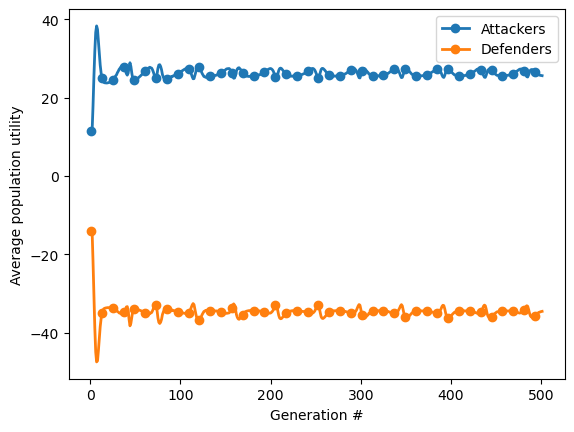

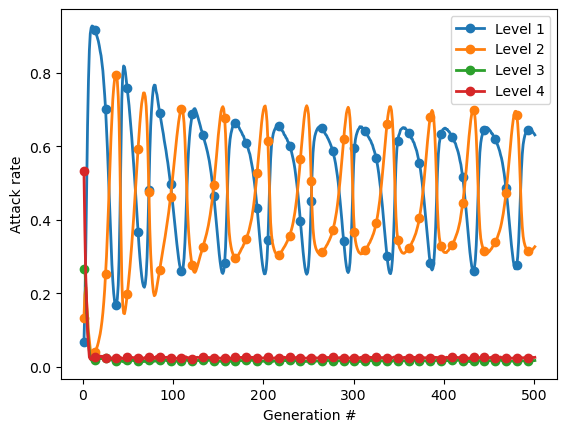

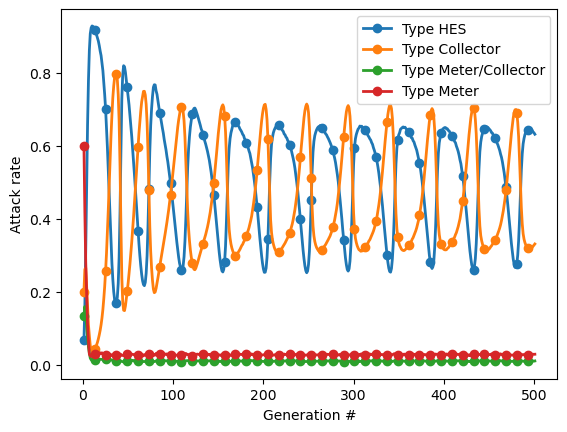

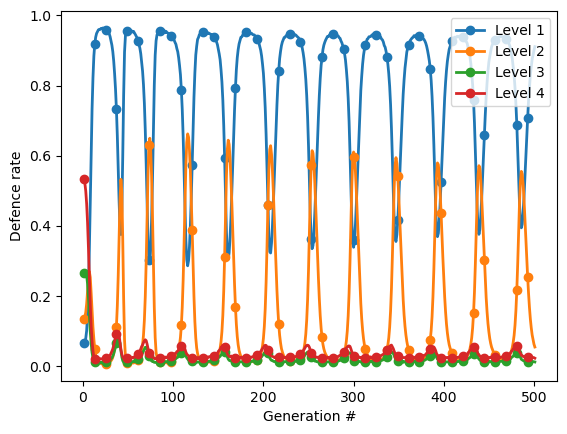

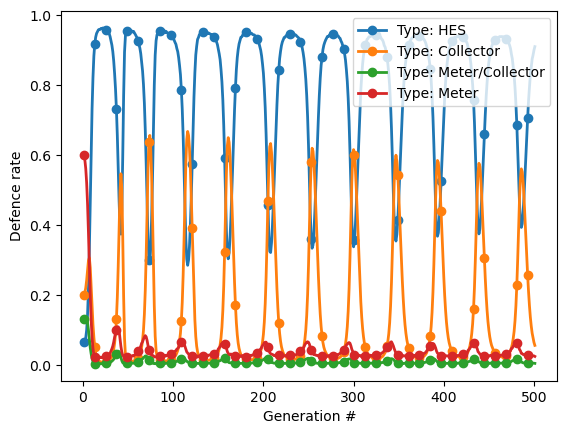

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

colors = ['red', 'blue', 'black', 'orange', 'green', 'purple']
linewidth = 2.0

# Load data
attacker_data = np.genfromtxt('attackers')
defender_data = np.genfromtxt('defenders')
utility_data = np.genfromtxt('utility')
type_data = np.genfromtxt('node_types.txt')
type_names = ['HES','Collector', 'Meter/Collector', 'Meter'] 

generations = attacker_data.shape[0]
if generations > 40:
    markfreq = int(generations/40)
else:
    markfreq = 1

attacker_data_type = np.zeros((generations, 4))
attacker_data_level = np.zeros((generations, 4))

defender_data_type = np.zeros((generations, 4))
defender_data_level = np.zeros((generations, 4))

for i in range(0, attacker_data.shape[1]):
    attacker_data_type[:, int(type_data[i, 0])] += attacker_data[:, i]
    attacker_data_level[:, int(type_data[i, 1])] += attacker_data[:, i]

for i in range(0, defender_data.shape[1]):
    defender_data_type[:, int(type_data[i, 0])] += defender_data[:, i]
    defender_data_level[:, int(type_data[i, 1])] += defender_data[:, i]

# Utility evolution
plt.figure(3)
gens = range(1, utility_data.shape[0]+1) 
plt.plot(gens, utility_data[:, 0], marker='o', 
        markevery=markfreq,
        linewidth=linewidth,
            label='Attackers')
plt.plot(gens, utility_data[:, 1], marker='o', 
        markevery=markfreq,
        linewidth=linewidth,
            label='Defenders')

plt.ylabel('Average population utility')
plt.xlabel('Generation #')
plt.legend(loc='best')
plt.savefig('utility_evolution.pdf')

# Attacker level evolution
plt.figure(4) 
for i in range(0, attacker_data_level.shape[1]):
    gens = range(1, generations+1) 
    plt.plot(gens, attacker_data_level[:, i], marker='o',
            markevery=markfreq,
            linewidth=linewidth,
                label='Level '+str(i+1))
plt.ylabel('Attack rate')
plt.xlabel('Generation #')
plt.legend(loc='upper right')
plt.savefig('attack_rate_level_evolution.pdf')

# Attacker type evolution
plt.figure(5) 
for i in range(0, attacker_data_type.shape[1]):
    gens = range(1, generations+1) 
    plt.plot(gens, attacker_data_type[:, i], marker='o',
            markevery=markfreq,
            linewidth=linewidth,
                label='Type '+type_names[i])
plt.ylabel('Attack rate')
plt.xlabel('Generation #')
plt.legend(loc='upper right')
plt.savefig('attack_rate_type_evolution.pdf')

# Defender level evolution
plt.figure(6) 
for i in range(0, defender_data_level.shape[1]):
    gens = range(1, generations+1) 
    plt.plot(gens, defender_data_level[:, i], marker='o',
            markevery=markfreq,
            linewidth=linewidth,
                label='Level '+str(i+1))
plt.ylabel('Defence rate')
plt.xlabel('Generation #')
plt.legend(loc='upper right')
plt.savefig('defence_rate_level_evolution.pdf')

# Defender type evolution
plt.figure(7) 
for i in range(0, defender_data_type.shape[1]):
    gens = range(1, generations+1) 
    plt.plot(gens, defender_data_type[:, i], marker='o',
            markevery=markfreq,
            linewidth=linewidth,
            label='Type: '+type_names[i])
plt.ylabel('Defence rate')
plt.xlabel('Generation #')
plt.legend(loc='upper right')
plt.savefig('defence_rate_type_evolution.pdf')

plt.show()


In [6]:
pip install egt

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement egt (from versions: none)
ERROR: No matching distribution found for egt


In [5]:
from egtplot import plot_static

ModuleNotFoundError: No module named 'egtplot'